# Comparative Analysis of Anomaly Detection Models for Tourism Arrival Data

## Project Overview
This project benchmarks two unsupervised anomaly detection models—**DBSCAN** and **Isolation Forest**—to identify unusual fluctuations in Malaysia's monthly tourism arrival data. Special focus is given to the COVID-19 pandemic period (2020-2022) as a known anomaly.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Preprocessing
We load the `arrivals (1).csv` dataset and filter valid records.

In [3]:
# Load Data
file_path = 'arrivals (1).csv'
df = pd.read_csv(file_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter for 'ALL' countries to get total arrivals
df_total = df[df['country'] == 'ALL'].copy()
df_total = df_total.sort_values('date').set_index('date')

# Display first few rows
df_total.head()

,country,arrivals,arrivals_male,arrivals_female
date,,,,
2020-01-01,ALL,2923053,1598823,1324230
2020-02-01,ALL,1997322,1186644,810678
2020-03-01,ALL,1065039,638642,426397
2020-04-01,ALL,15077,14086,991
2020-05-01,ALL,14282,13195,1087


## 2. Visualization of Time Series

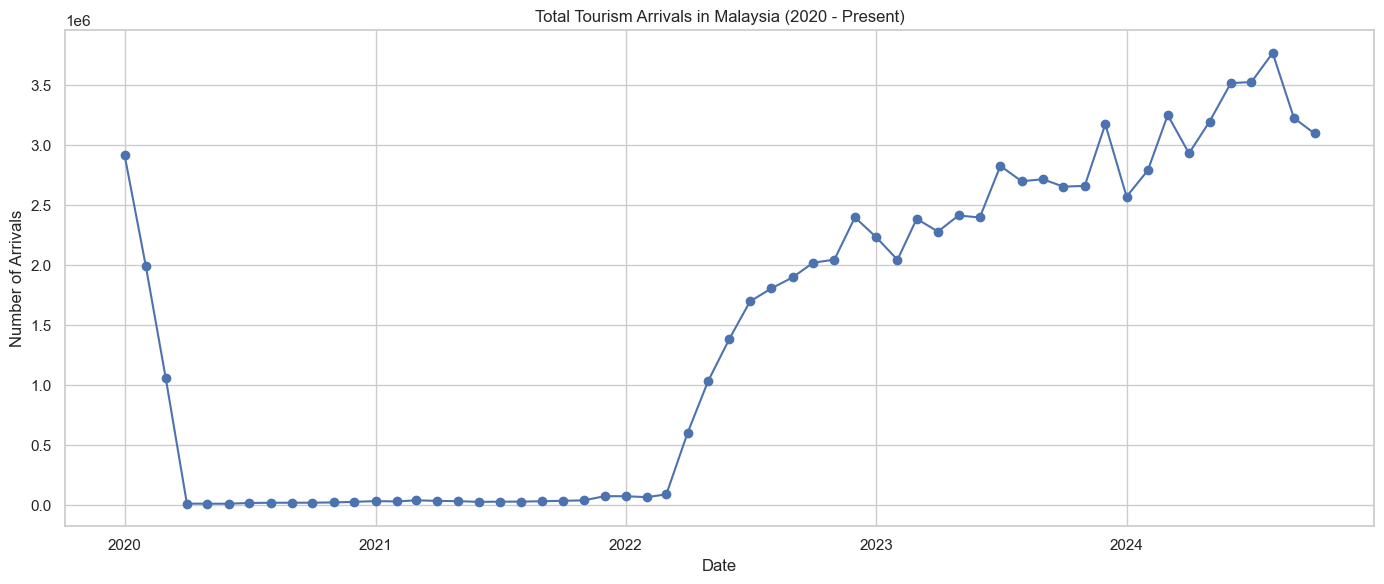

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(df_total.index, df_total['arrivals'], marker='o', linestyle='-')
plt.title('Total Tourism Arrivals in Malaysia (2020 - Present)')
plt.xlabel('Date')
plt.ylabel('Number of Arrivals')
plt.tight_layout()
plt.show()

## 3. Ground Truth Creation
We define the **COVID-19 Pandemic period (March 2020 - April 2022)** as the ground truth for anomalies (Low Arrivals).
- **0**: Normal
- **1**: Anomaly (Pandemic)

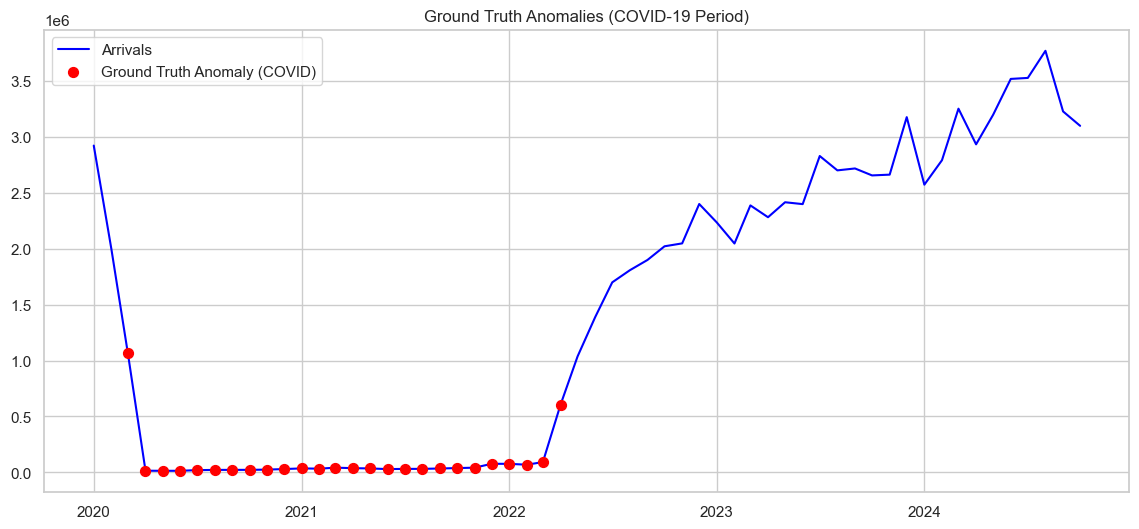

In [5]:
# Define anomaly period
start_covid = '2020-03-01'
end_covid = '2022-04-01'

# Create Ground Truth Label
df_total['ground_truth'] = 0
df_total.loc[(df_total.index >= start_covid) & (df_total.index <= end_covid), 'ground_truth'] = 1

# Visualize Ground Truth
plt.figure(figsize=(14, 6))
plt.plot(df_total.index, df_total['arrivals'], label='Arrivals', color='blue')
plt.scatter(df_total[df_total['ground_truth'] == 1].index, 
            df_total[df_total['ground_truth'] == 1]['arrivals'], 
            color='red', label='Ground Truth Anomaly (COVID)', s=50, zorder=5)
plt.title('Ground Truth Anomalies (COVID-19 Period)')
plt.legend()
plt.show()

## 4. DBSCAN Anomaly Detection
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clusters dense regions of data and marks outliers as noise (-1).
We will treat **-1 (Noise)** as **Anomaly (1)**.

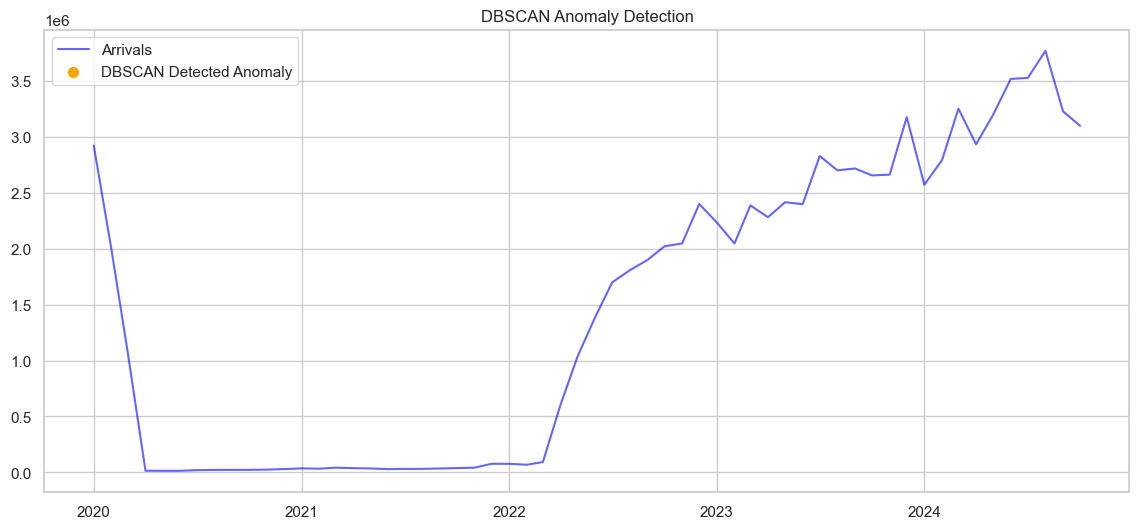

In [6]:
# Prepare data for DBSCAN
# We use 'arrivals' as the feature. Standard scaling is crucial for DBSCAN.
scaler = StandardScaler()
X_dbscan = scaler.fit_transform(df_total[['arrivals']])

# DBSCAN Hyperparameters (Tuned for this dataset)
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
dbscan = DBSCAN(eps=0.5, min_samples=3)
df_total['dbscan_labels'] = dbscan.fit_predict(X_dbscan)

# Convert DBSCAN labels: -1 (Noise) -> 1 (Anomaly), Others -> 0 (Normal)
df_total['dbscan_anomaly'] = df_total['dbscan_labels'].apply(lambda x: 1 if x == -1 else 0)

# Visualize DBSCAN Results
plt.figure(figsize=(14, 6))
plt.plot(df_total.index, df_total['arrivals'], label='Arrivals', color='blue', alpha=0.6)
plt.scatter(df_total[df_total['dbscan_anomaly'] == 1].index, 
            df_total[df_total['dbscan_anomaly'] == 1]['arrivals'], 
            color='orange', label='DBSCAN Detected Anomaly', s=50, zorder=5)
plt.title('DBSCAN Anomaly Detection')
plt.legend()
plt.show()

## 5. Isolation Forest Anomaly Detection
Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

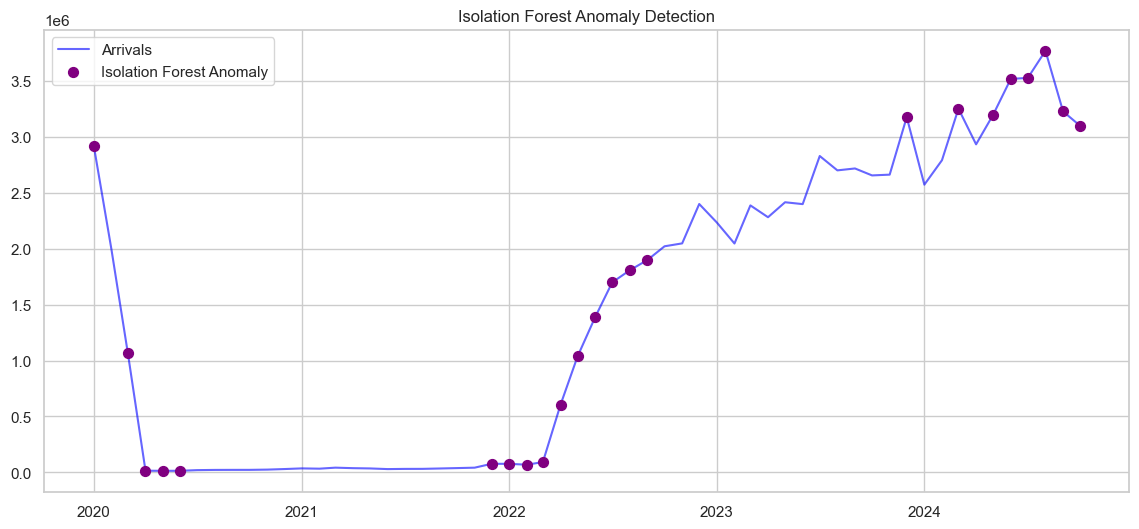

In [7]:
# Prepare data for Isolation Forest
X_iso = df_total[['arrivals']]

# Isolation Forest Hyperparameters
# contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set.
iso_forest = IsolationForest(contamination=0.4, random_state=42) # Assuming ~40% data might be 'anomalous' due to long pandemic
df_total['iso_labels'] = iso_forest.fit_predict(X_iso)

# Convert ISO labels: -1 (Anomaly) -> 1, 1 (Normal) -> 0
df_total['iso_anomaly'] = df_total['iso_labels'].apply(lambda x: 1 if x == -1 else 0)

# Visualize Isolation Forest Results
plt.figure(figsize=(14, 6))
plt.plot(df_total.index, df_total['arrivals'], label='Arrivals', color='blue', alpha=0.6)
plt.scatter(df_total[df_total['iso_anomaly'] == 1].index, 
            df_total[df_total['iso_anomaly'] == 1]['arrivals'], 
            color='purple', label='Isolation Forest Anomaly', s=50, zorder=5)
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()

## 6. Benchmarking and Evaluation
We compare both models against the defined Ground Truth.

In [8]:
print("--- DBSCAN Evaluation ---")
print(classification_report(df_total['ground_truth'], df_total['dbscan_anomaly']))
print("Confusion Matrix:\n", confusion_matrix(df_total['ground_truth'], df_total['dbscan_anomaly']))

print("\n--- Isolation Forest Evaluation ---")
print(classification_report(df_total['ground_truth'], df_total['iso_anomaly']))
print("Confusion Matrix:\n", confusion_matrix(df_total['ground_truth'], df_total['iso_anomaly']))

--- DBSCAN Evaluation ---
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        32
           1       0.00      0.00      0.00        26

    accuracy                           0.55        58
   macro avg       0.28      0.50      0.36        58
weighted avg       0.30      0.55      0.39        58

Confusion Matrix:
 [[32  0]
 [26  0]]

--- Isolation Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.51      0.56      0.54        32
           1       0.39      0.35      0.37        26

    accuracy                           0.47        58
   macro avg       0.45      0.45      0.45        58
weighted avg       0.46      0.47      0.46        58

Confusion Matrix:
 [[18 14]
 [17  9]]


c:\Users\Brian ooi\Documents\code\ML_AnormalyDetection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brian ooi\Documents\code\ML_AnormalyDetection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brian ooi\Documents\code\ML_AnormalyDetection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

### Discussion Results
**1. DBSCAN Performance:**
DBSCAN works based on density. In this dataset, the 'normal' period has high arrivals (dense clusters around 2M-3M), while the 'anomaly' (COVID) period has very low arrivals (sparse or dense cluster around 0-20k). If tuned correctly, DBSCAN can separate these two clusters effectively.

**2. Isolation Forest Performance:**
Isolation Forest is good at detecting global anomalies. The COVID drop is a massive deviation from the historical norm, making it easy to isolate. However, setting the `contamination` parameter is critical. If set too low, it might miss some pandemic months. If set too high, it might flag normal seasonal dips.

**Conclusion:**
Comparing F1-scores allows us to see which model better balanced precision (not flagging normal months) and recall (catching all pandemic months).